Energy required for mission (no reserve): 72.75 kWh
Reserve margin (15%): 10.91 kWh
Total battery energy required: 83.66 kWh


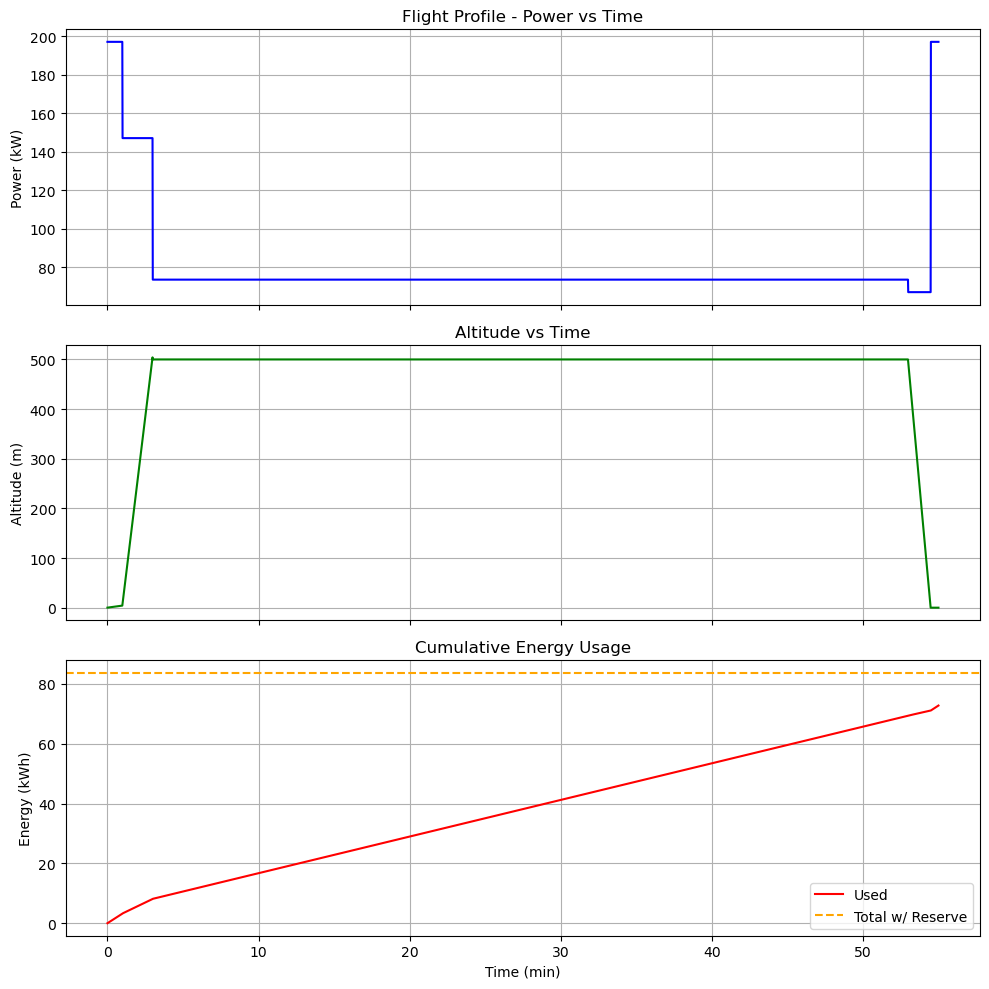

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Adjustable Parameters ---
payload_mass_kg = 300        # Total passenger + luggage payload
wind_speed = 5               # Headwind in m/s
temperature = 35             # Outside temp in °C
reserve_margin = 0.15        # Reserve energy as 15%

# --- Constants ---
hover_time = 60         # Takeoff hover duration in seconds
climb_time = 120
cruise_time = 3000      # 100 km at ~120 km/h
descend_time = 90
land_hover_time = 30
total_time = hover_time + climb_time + cruise_time + descend_time + land_hover_time

# Base power usage (kW)
base_power = {
    "hover": 180,
    "climb": 130,
    "cruise": 54,
    "descend": 50,
    "land_hover": 180
}

# --- Adjustments for environment ---
# Wind penalty: increase cruise power with headwind
wind_penalty = 0.5 * wind_speed   # simplified penalty model
# Temp penalty: higher temp reduces motor efficiency, thus needs more power
temp_penalty = 0.2 * max(0, temperature - 25)

# Power usage per phase
power_hover = base_power["hover"] + temp_penalty
power_climb = base_power["climb"] + temp_penalty
power_cruise = base_power["cruise"] + wind_penalty + temp_penalty
power_descend = base_power["descend"] + temp_penalty
power_land_hover = base_power["land_hover"] + temp_penalty

# Add payload penalty (approx. 0.05 kW per kg over base)
payload_penalty = payload_mass_kg * 0.05
power_hover += payload_penalty
power_climb += payload_penalty
power_cruise += payload_penalty
power_descend += payload_penalty
power_land_hover += payload_penalty

# --- Time Vector ---
t = np.arange(0, total_time + 1)
power_profile = np.zeros_like(t, dtype=float)
altitude_profile = np.zeros_like(t, dtype=float)
energy_used = np.zeros_like(t, dtype=float)

# Altitude settings
cruise_altitude = 500
climb_rate = cruise_altitude / climb_time
descend_rate = cruise_altitude / descend_time
altitude = 0

# Populate simulation profiles
for i, time in enumerate(t):
    if time < hover_time:
        power = power_hover
        altitude += climb_rate / hover_time
    elif time < hover_time + climb_time:
        power = power_climb
        altitude += climb_rate
    elif time < hover_time + climb_time + cruise_time:
        power = power_cruise
        altitude = cruise_altitude
    elif time < hover_time + climb_time + cruise_time + descend_time:
        power = power_descend
        altitude -= descend_rate
    else:
        power = power_land_hover
        altitude = 0
    power_profile[i] = power
    altitude_profile[i] = altitude
    if i > 0:
        energy_used[i] = energy_used[i-1] + power / 3600  # kWh per sec

# Add energy reserve margin
final_energy = energy_used[-1]
reserve_energy = final_energy * reserve_margin
total_energy_required = final_energy + reserve_energy

# --- Output ---
print(f"Energy required for mission (no reserve): {final_energy:.2f} kWh")
print(f"Reserve margin ({int(reserve_margin * 100)}%): {reserve_energy:.2f} kWh")
print(f"Total battery energy required: {total_energy_required:.2f} kWh")

# --- Plotting ---
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

axs[0].plot(t / 60, power_profile, color="blue")
axs[0].set_ylabel("Power (kW)")
axs[0].set_title("Flight Profile - Power vs Time")
axs[0].grid(True)

axs[1].plot(t / 60, altitude_profile, color="green")
axs[1].set_ylabel("Altitude (m)")
axs[1].set_title("Altitude vs Time")
axs[1].grid(True)

axs[2].plot(t / 60, energy_used, color="red", label="Used")
axs[2].axhline(y=total_energy_required, color="orange", linestyle="--", label="Total w/ Reserve")
axs[2].set_xlabel("Time (min)")
axs[2].set_ylabel("Energy (kWh)")
axs[2].set_title("Cumulative Energy Usage")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()
